# **ASSIGNMENT 2 - CLUSTERING**

## **Submitted by:**
- **Ladrera**, Raiken Lee
- **Tibon**, Hestia  

-----

## **1. Introduction**

@all  Assignment 2 For Clustering: Sessa Empirical Estimator
1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.
6. Deadline is this Sunday, Feb 23, 2022 at 11:59 pm
7. Do this with your thesis partner.
8. You can use any A.I. assistant.

<hr>

## **2. Exploratory Data Analysis**

### **2.1 Importing necessary packages and libraries**

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist
from datetime import datetime

### **2.2 Importing the dataset**

In [91]:
# Load the dataset [The simulated data is acquired from https://github.com/Masswear/BeyondThresholds]
df = pd.read_csv("med_events.csv")

# Convert DATE column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

### **2.3 Basic information of the dataset**

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275 entries, 0 to 2274
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   PATIENT_ID  2275 non-null   int64         
 1   DATE        2275 non-null   datetime64[ns]
 2   PERDAY      2275 non-null   int64         
 3   CATEGORY    2275 non-null   object        
 4   DURATION    2275 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 89.0+ KB


In [93]:
df.isnull().sum()

PATIENT_ID    0
DATE          0
PERDAY        0
CATEGORY      0
DURATION      0
dtype: int64

In [94]:
df.rename(columns={
    "PATIENT_ID": "pnr",
    "DATE": "eksd",
    "PERDAY": "perday",
    "CATEGORY": "ATC",
    "DURATION": "dur_original"
}, inplace=True)
df.drop(columns=["CATEGORY_ENCODED"], errors="ignore", inplace=True)
df["perday"] = df["perday"].round().astype(int)
df["dur_original"] = df["dur_original"].round().astype(int)

### **2.5 Descriptive Statistics**

In [95]:
df.describe()

,pnr,eksd,perday,dur_original
count,2275.000000,2275,2275.000000,2275.000000
mean,46.050549,2024-02-03 03:53:33.890109696,7.959560,44.778022
min,1.000000,2022-01-01 00:00:00,2.000000,20.000000
25%,23.000000,2022-11-04 00:00:00,4.000000,30.000000
50%,46.000000,2023-12-23 00:00:00,6.000000,50.000000
75%,69.000000,2025-03-06 12:00:00,8.000000,50.000000
max,100.000000,2028-10-08 00:00:00,20.000000,100.000000
std,26.366232,NaN,6.260129,16.971222


### **2.6 Look for unique values**

In [96]:
print("\nUnique Patients:", df['pnr'].nunique())
print("Unique Medication Categories:", df['ATC'].nunique())


Unique Patients: 100
Unique Medication Categories: 2


### **2.7 Distribution of numerical variables**

C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


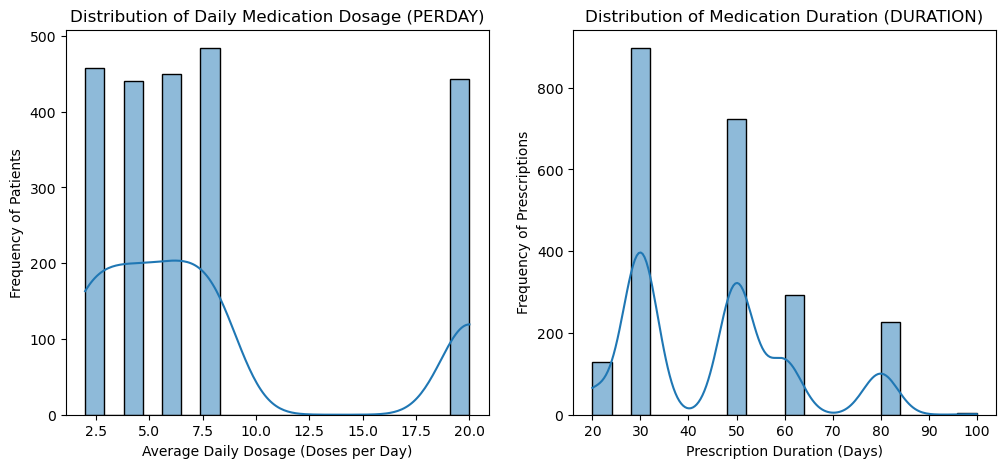

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['perday'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Daily Medication Dosage (PERDAY)')
axes[0].set_xlabel('Average Daily Dosage (Doses per Day)')
axes[0].set_ylabel('Frequency of Patients')

sns.histplot(df['dur_original'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Medication Duration (DURATION)')
axes[1].set_xlabel('Prescription Duration (Days)')
axes[1].set_ylabel('Frequency of Prescriptions')
plt.show()

### **2.8 Medication trends**

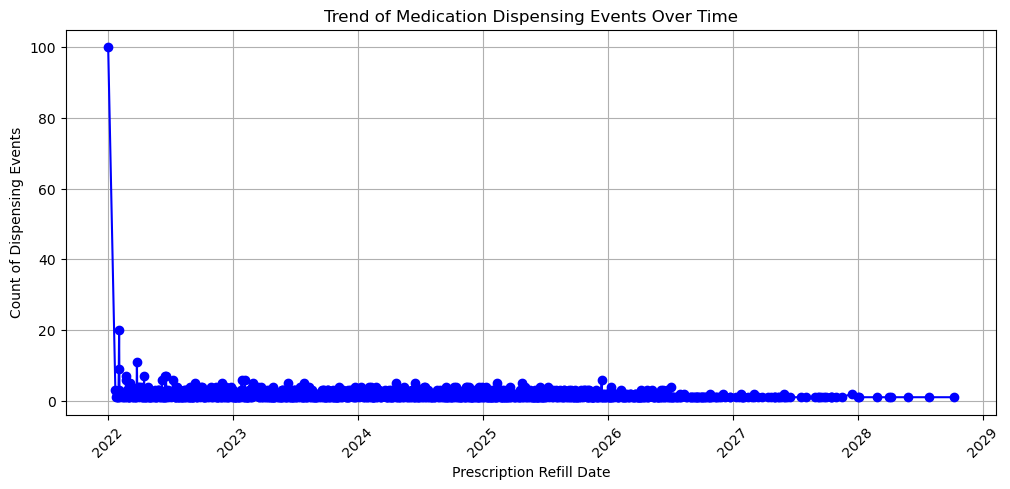

In [98]:
df_time_series = df.groupby('eksd').size()
plt.figure(figsize=(12, 5))
plt.plot(df_time_series, marker='o', linestyle='-', color='b')
plt.title('Trend of Medication Dispensing Events Over Time')
plt.xlabel('Prescription Refill Date')
plt.ylabel('Count of Dispensing Events')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### **2.8 Check for outliers**

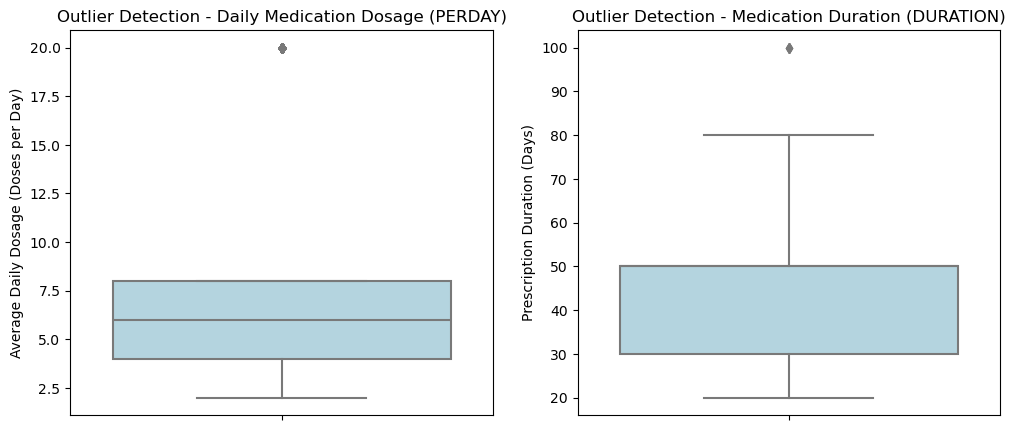

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=df['perday'], ax=axes[0], color='lightblue')
axes[0].set_title('Outlier Detection - Daily Medication Dosage (PERDAY)')
axes[0].set_ylabel('Average Daily Dosage (Doses per Day)')

sns.boxplot(y=df['dur_original'], ax=axes[1], color='lightblue')
axes[1].set_title('Outlier Detection - Medication Duration (DURATION)')
axes[1].set_ylabel('Prescription Duration (Days)')
plt.show()

### **2.9 Category distribution**

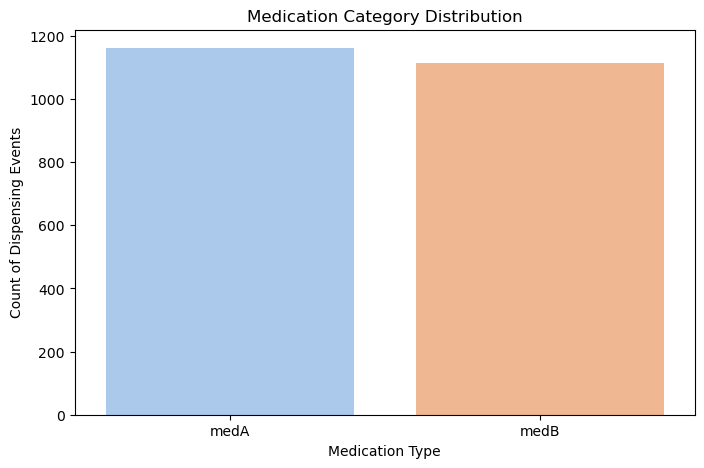

In [100]:
plt.figure(figsize=(8,5))
sns.countplot(x=df['ATC'], order=df['ATC'].value_counts().index, palette='pastel')
plt.title('Medication Category Distribution')
plt.xlabel('Medication Type')
plt.ylabel('Count of Dispensing Events')
plt.show()

In [101]:
# Encoding CATEGORY column
label_encoder = LabelEncoder()
df['CATEGORY_ENCODED'] = label_encoder.fit_transform(df['ATC'])

### **2.10 Correlation Heatmap**

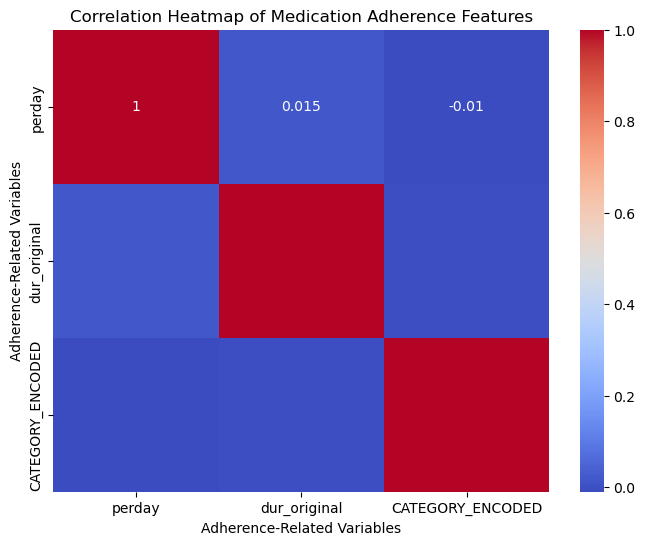

In [102]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['perday', 'dur_original', 'CATEGORY_ENCODED']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Medication Adherence Features')
plt.xlabel('Adherence-Related Variables')
plt.ylabel('Adherence-Related Variables')
plt.show()

### **2.11 Pairplot for feature relationships**

C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


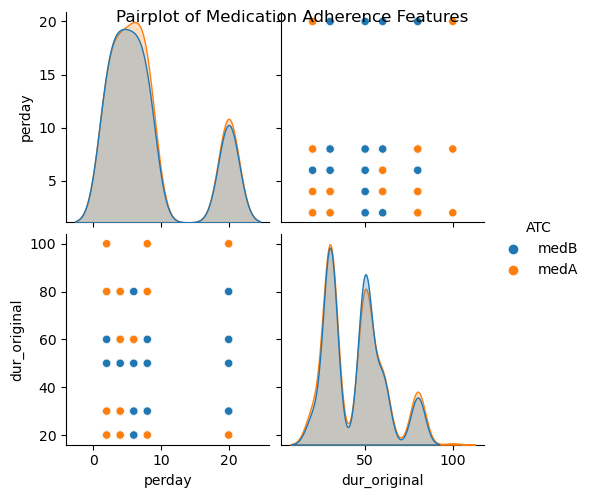

In [103]:
sns.pairplot(df, vars=['perday', 'dur_original'], hue='ATC', diag_kind='kde')
plt.suptitle('Pairplot of Medication Adherence Features')
plt.show()

In [104]:
# Standardizing numerical features
scaler = StandardScaler()
df[['perday', 'dur_original', 'CATEGORY_ENCODED']] = scaler.fit_transform(df[['perday', 'dur_original', 'CATEGORY_ENCODED']])

<hr>

## **3. Clustering**

In [105]:
if "CATEGORY_ENCODED" in df.columns:
    df = df.drop(columns=["CATEGORY_ENCODED"])

### **3.1 Callable functions**

# **3.1.1 SEE using K-means clustering definition**

In [106]:
def SEE(arg1):
    # Filter dataset based on medication category
    C09CA01 = df[df["ATC"] == arg1].copy()
    
    # Sort by patient and prescription date
    C09CA01 = C09CA01.sort_values(by=["pnr", "eksd"]).copy()
    
    # Compute previous prescription date
    C09CA01["prev_eksd"] = C09CA01.groupby("pnr")["eksd"].shift(1)
    C09CA01.dropna(subset=["prev_eksd"], inplace=True)
    
    # Compute event interval (time difference in days)
    C09CA01["event_interval"] = (C09CA01["eksd"] - C09CA01["prev_eksd"]).dt.days
    
    # Generate ECDF
    sorted_intervals = np.sort(C09CA01["event_interval"].values)
    yvals = np.arange(1, len(sorted_intervals)+1) / len(sorted_intervals)
    dfper = pd.DataFrame({"x": sorted_intervals, "y": yvals})
    dfper = dfper[dfper["y"] <= 0.8]  # Retain lower 80% of ECDF
    
    # ECDF Visualization
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].scatter(dfper["x"], dfper["y"], color='red', s=50)
    axs[0].set_title("80% ECDF")
    axs[1].scatter(sorted_intervals, yvals, color='blue',  s=50)
    axs[1].set_title("100% ECDF")
    plt.show()
    
    # Density Estimation
    log_intervals = np.log(dfper["x"])
    kde = gaussian_kde(log_intervals)
    x_vals = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    plt.plot(x_vals, kde(x_vals), color='green')
    plt.title("Log(Event Interval) Density Plot")
    plt.show()
    
    # Silhouette Score for Optimal Clustering
    X = dfper[["x"]].values
    X_scaled = StandardScaler().fit_transform(X)
    best_k = 2
    best_score = -1
    for k in range(2, 10):
        km = KMeans(n_clusters=k, random_state=1234).fit(X_scaled)
        score = silhouette_score(X_scaled, km.labels_)
        if score > best_score:
            best_score = score
            best_k = k
    
    # K-Means Clustering
    kmeans = KMeans(n_clusters=best_k, random_state=1234).fit(X_scaled)
    dfper["cluster"] = kmeans.labels_
    
    # Compute cluster summary statistics
    cluster_summary = dfper.groupby("cluster")["x"].agg(["min", "max", "median"]).reset_index()
    
    # Assign Cluster to Data
    C09CA01 = C09CA01.merge(cluster_summary, left_on="event_interval", right_on="min", how="left")
    C09CA01["cluster"] = C09CA01["cluster"].fillna(0).astype(int)
    
    return C09CA01

### **3.1.2 SEE assumption**

In [107]:
def see_assumption(arg1):
    if arg1.empty:
        print("Warning: No valid data for boxplot.")
        return np.nan

    arg1 = arg1.sort_values(by=["pnr", "eksd"]).copy()
    arg1["prev_eksd"] = arg1.groupby("pnr")["eksd"].shift(1)
    arg1["p_number"] = arg1.groupby("pnr").cumcount() + 1
    
    Drug_see2 = arg1[arg1["p_number"] >= 2].copy()

    print(f"Total Rows Before Filtering: {arg1.shape[0]}")
    print(f"Total Rows After Filtering (p_number ≥ 2): {Drug_see2.shape[0]}")
    
    if Drug_see2.empty:
        print("Warning: No valid Duration values for boxplot.")
        return np.nan

    Drug_see2["Duration"] = (Drug_see2["eksd"] - Drug_see2["prev_eksd"]).dt.days
    Drug_see2["p_number"] = Drug_see2["p_number"].astype("category")

    plt.figure(figsize=(8, 6))
    sns.boxplot(x="p_number", y="Duration", data=Drug_see2)
    plt.title("Boxplot of Duration by p_number")
    plt.xlabel("Prescription Sequence")
    plt.ylabel("Duration (Days)")

    medians_of_medians = Drug_see2.groupby("pnr")["Duration"].median().reset_index(name="median_duration")
    plt.axhline(y=medians_of_medians["median_duration"].median(), color="red", linestyle="dashed", alpha=0.5)

    plt.tight_layout()
    plt.show()

    return

### **3.2 Sessa Empirical Estimator using K-Means**

### **3.2.1 ATC = medA**

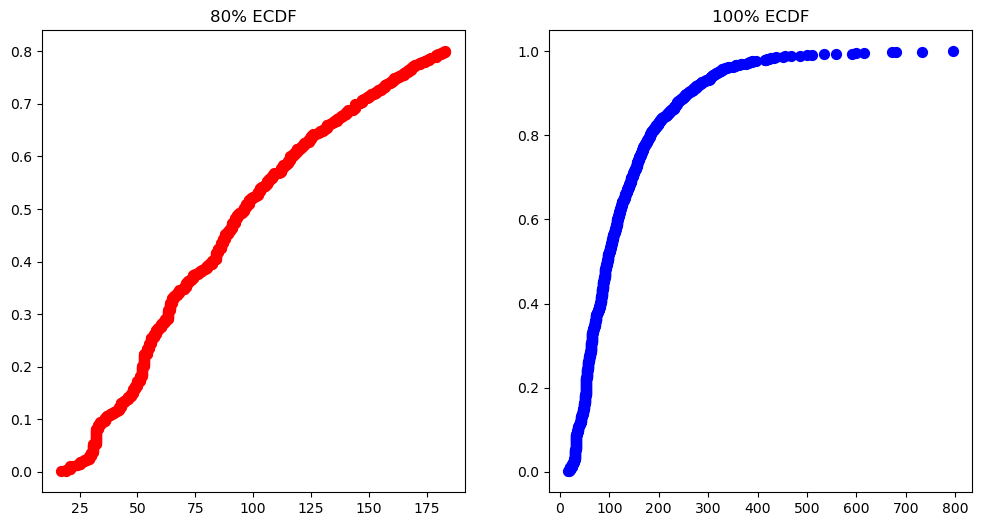

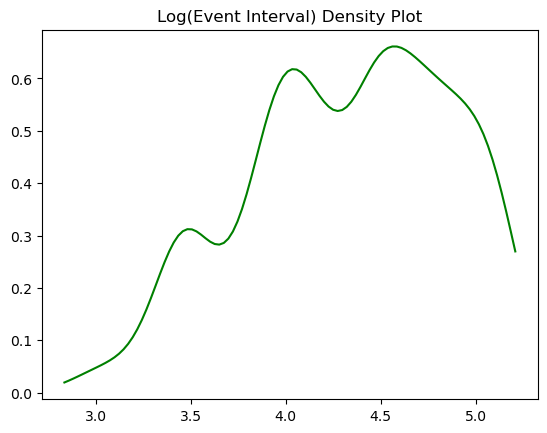

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment v

In [108]:
medA = SEE("medA")

### **3.2.2 ATC = medB**

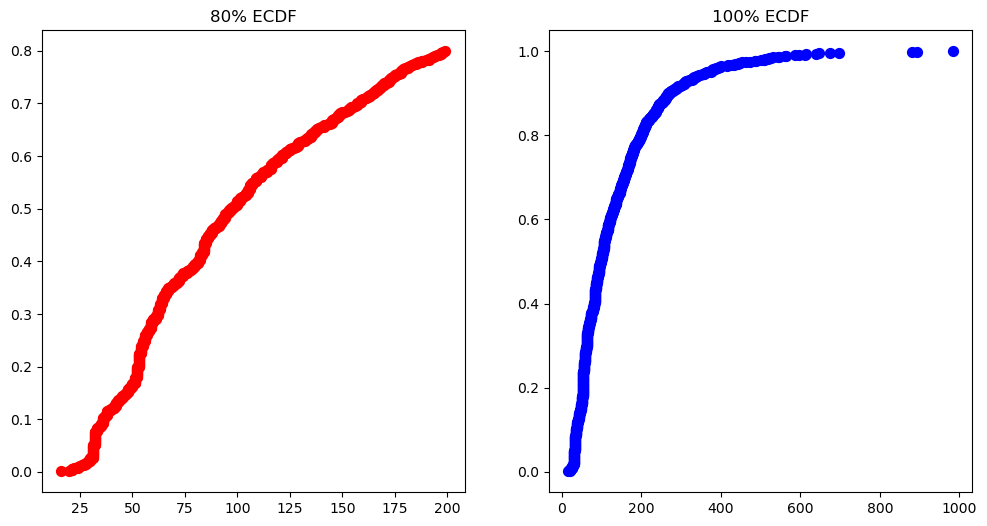

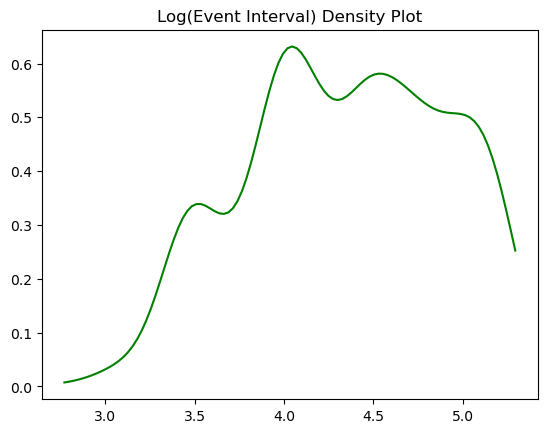

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment v

In [109]:
medB = SEE("medB")

### **3.2.3 SEE Assumption of medA**

Total Rows Before Filtering: 1065
Total Rows After Filtering (p_number ≥ 2): 972


C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


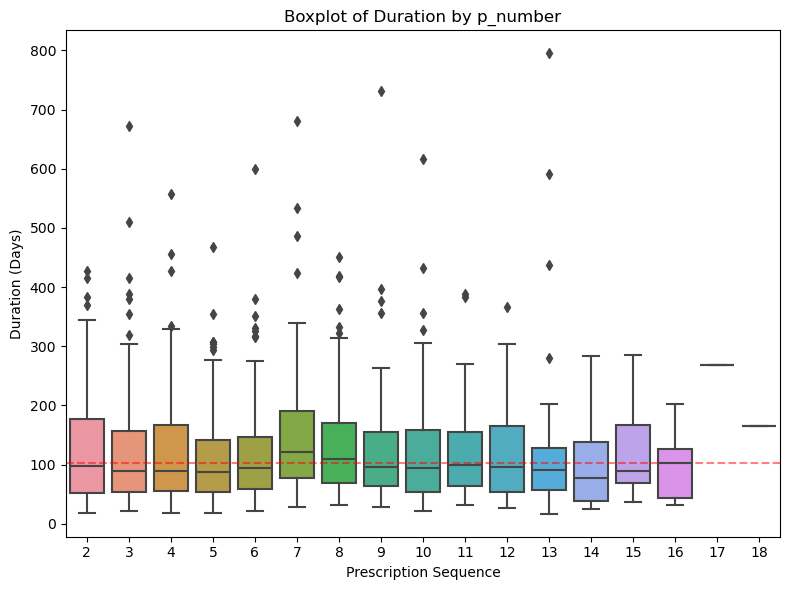

In [110]:
see_assumption(medA)

### **3.2.4 SEE Assumption of medB**

Total Rows Before Filtering: 1016
Total Rows After Filtering (p_number ≥ 2): 920


C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


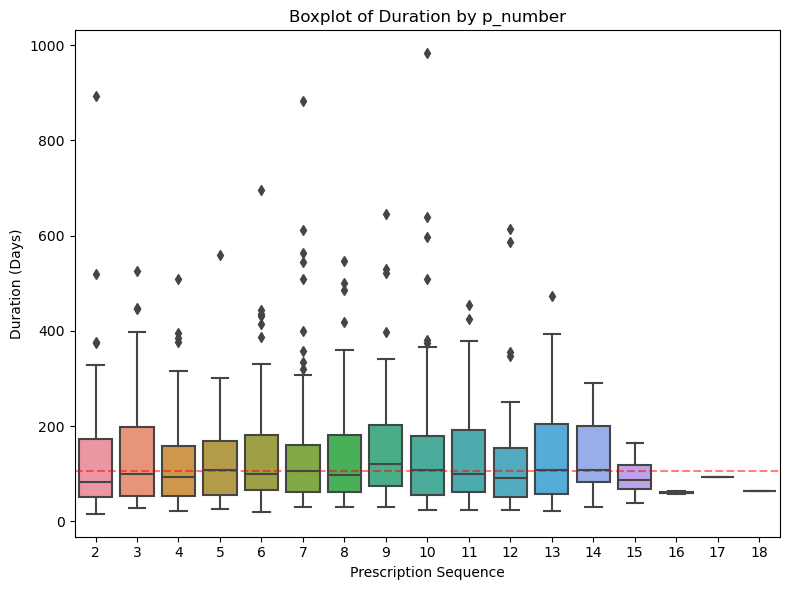

In [111]:
see_assumption(medB)

### **3.3 Sessa Empirical Estimator using Hierarchal Clustering**